<a href="https://colab.research.google.com/github/fabnancyuhp/DEEP-LEARNING/blob/main/NOTEBOOKS/text-mining-with-recurrent-neural-networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we work a news database. We will solve 2 problems:
* We first design a model to predict if a news is a fake one or not.
* In a second application, we buid a model that able to detect the topic of a news text 

We provide some useful functions to clean text databases.

# Data cleaning functions
here, we provide some useful functions to clean text data. We call these functions during preprocessing text data.

In [1]:
import re

#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data


#Removes URL data
def _remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)


#Removes dups char
def _remove_dups_char(x):
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x


#Removes emails
def _remove_emails(x):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)


def _remove_rt(x):
    return re.sub(r'\brt\b', '', x).strip()

def _remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

# Example 1 : Fake news detection using LSTM 
In this section, we want to make a model to predict fake news. Our dataset corresponds to a corpus of fake and real news. We first import some useful libraries.<br>
We will be using an LSTM to evaluate whether or not a text correspond to a fake news. We start by importing the dataset:

In [3]:
import pandas as pd
Fake = pd.read_parquet("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/Fake.parquet.brotli")
Real = pd.read_parquet("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/Real.parquet.brotli")
Fake = Fake.loc[~(Fake['text'].str.strip().str.len()==0)]
Real = Real.loc[~(Real['text'].str.strip().str.len()==0)]
Real['text'] = Real['title']+ " " +Real['text']
Fake['text'] = Fake['title']+ " " +Fake['text']
Real['class'] = 1
Fake['class'] = 0
Real = Real[['class','text']]
Fake = Fake[['class','text']]
real_fake_news = pd.concat([Real,Fake]).sample(frac=1.0)

## First step, We draw 2 wordclouds to compare fake news and real news
It's hard to distinguish the wordcloud from the fake news and from the real news.

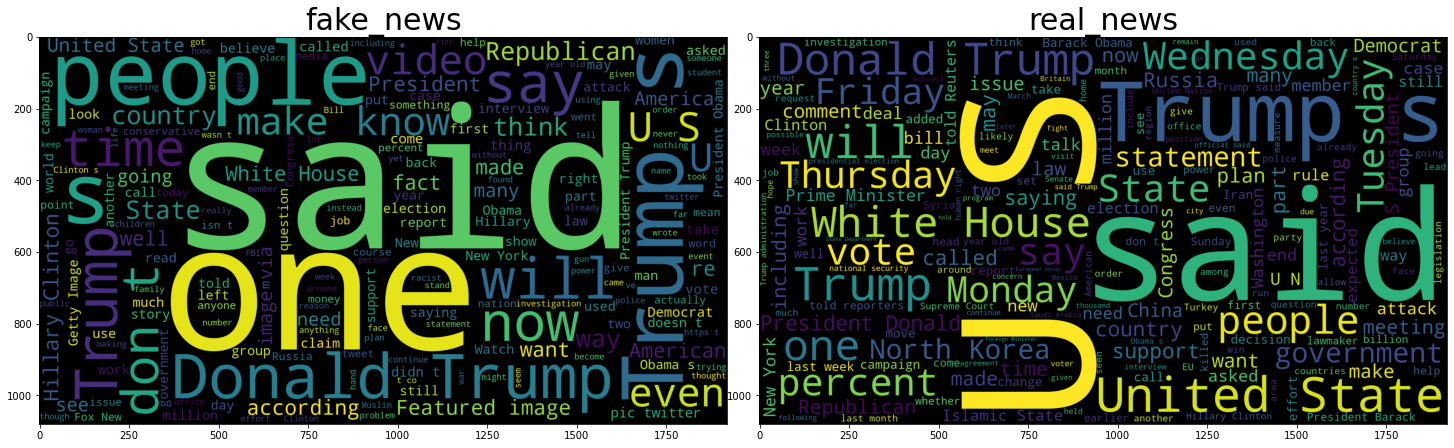

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from wordcloud import WordCloud

text_fake = ' '.join(Fake['text'].tolist())
wordcloud_fake = WordCloud(width=1920,height=1080).generate(text_fake)
text_real = ' '.join(Real['text'].tolist())
wordcloud_real = WordCloud(width=1920,height=1080).generate(text_real)
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(wordcloud_fake)
plt.tight_layout(pad=0)
plt.title("fake_news",fontsize =30)

plt.subplot(122)
plt.imshow(wordcloud_real)
plt.tight_layout(pad=0)
plt.title("real_news",fontsize =30)
plt.show()

## Step 2 :preprocessing the text data
* We convert the text in lowercase
* We remove html tags, url tags, emails, ponctuations and emails.

In [4]:
real_fake_news['text'] = real_fake_news['text'].apply(lambda x:str(x).lower()).replace('_', ' ') #.replace('\\', '').replace('_', ' '))
real_fake_news['text'] = real_fake_news['text'].apply(lambda x:remove_html(str(x)))
real_fake_news['text'] = real_fake_news['text'].apply(lambda x:_remove_urls(str(x)))
real_fake_news['text'] = real_fake_news['text'].apply(lambda x:remove_punctuations(str(x)))
real_fake_news['text'] = real_fake_news['text'].apply(lambda x:_remove_emails(str(x)))
real_fake_news['text'] = real_fake_news['text'].apply(lambda x:_remove_rt(str(x)))
real_fake_news['text'] = real_fake_news['text'].apply(lambda x:_remove_special_chars(str(x)))

## Step 3: text Tokenization
Tokenization is the process of breaking up a given text into units called tokens. Tokens can be individual words, phrases or even whole sentences. In the process of tokenization, some characters like punctuation marks may be discarded. The tokens usually become the input for the processes like parsing and text mining.<br>
In the cell below, 
* X is a list of tokens list.
* XBIS is a list of sequences. A sequence is a list of number

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

#X = [d.split() for d in list(real_fake_news['text'])]
X = real_fake_news['text'].to_numpy() 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
XBIS = tokenizer.texts_to_sequences(X)

In [6]:
print(X[1])
print(XBIS[1])

factbox whats next for catalonias exiled separatist leader exiled catalan separatist leader carles puigdemont looks set to regain power after regional elections on thursday but what comes next is unlikely to be an easy ride can he go back to catalonia puigdemont is targeted by an arrest warrant for his role in organizing an illegal independence referendum on oct 1 and leading the secession bid he is now in brussels but he faces arrest the minute he steps foot in spain seven of the 70 separatists elected on sunday are either in jail or in exile on allegations of sedition and rebellion unless they are released or they return home they cannot vote in parliament to form a workable majority they could hope to be freed or have arrest warrants dropped if they swore no to pursue independence unilaterally but that in turn could jeopardize support for a puigdemont government from catalonia s most vehement proindependence party the cup another option would be for these leaders to forfeit their se

We display a part of the word index we created with tensorflow.keras.preprocessing.text.Tokenizer. This index is a python dictionary.

In [7]:
index_word  = tokenizer.word_index
for x in list(index_word)[0:3]:
    print ("{}, {} ".format(x,  index_word[x]))

the, 1 
to, 2 
of, 3 


We study the length of text data. We draw a histogram of the size (count of words) of the news.

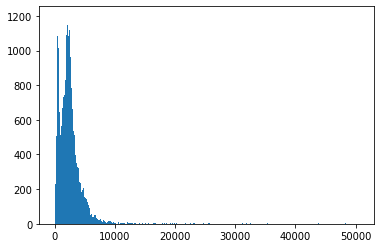

In [8]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in X],bins=700)
plt.show()

We truncate all texts which have more than 1000 words using pad_sequences. After we run the cell below, all texts are modelized in  1000 components vectors.

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
XTIER = pad_sequences(XBIS,maxlen=1000,padding='post')
XTIER[0:3]

array([[   14, 24382,   178, ...,     0,     0,     0],
       [ 4086,  4967,   226, ...,     0,     0,     0],
       [   14,     2,  1438, ...,     0,     0,     0]], dtype=int32)

The vocabulary size is equal to len(tokenizer.word_index)+1 to take into account the unknown words.

In [8]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

227502

## Step 4: Splitting the dataset into a training set and a test set
We use the train_test_split method to make a training set and a test set.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XTIER,real_fake_news['class'].values,test_size=0.33, random_state=42)

## Step 5: Building the model with tensorflow.keras
We want to predict the fake newsWe build a model with the following layers:
* an Embedding layer with input_dim=len(tokenizer.word_index)+1, input_length=1000. Since we want the dimension of the dense embedding is 100, we have to set output_dim=100.
* a LSTM layer with 128 units 
* a Dense layer. Since we have only 2 classes, in the last dense layer we choose the sigmoid activation function.

We compile this model with an adam optimizer, a binary_crossentropy loss function and the accuracy metric. We fit the model 

In [12]:
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential
vocab_size = len(tokenizer.word_index)+1

#model_fake_single = Sequential([Embedding(input_dim=vocab_size,output_dim=100),\
                                #LSTM(units=128),Dense(1,activation='sigmoid')])

model_fake_single = Sequential()
model_fake_single.add(Embedding(input_dim=vocab_size,output_dim=100))
model_fake_single.add(LSTM(units=128))
model_fake_single.add(Dense(1,activation='sigmoid'))

model_fake_single.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

model_fake_single.fit(X_train,y_train,epochs=8,validation_split=0.1)

Epoch 1/8
835/835 [==============================] - 53s 61ms/step - loss: 0.6862 - acc: 0.5142 - val_loss: 0.6781 - val_acc: 0.5280
Epoch 2/8
835/835 [==============================] - 52s 62ms/step - loss: 0.4662 - acc: 0.8003 - val_loss: 0.3791 - val_acc: 0.8699
Epoch 3/8
835/835 [==============================] - 50s 60ms/step - loss: 0.6389 - acc: 0.5689 - val_loss: 0.6754 - val_acc: 0.5297
Epoch 4/8
835/835 [==============================] - 50s 60ms/step - loss: 0.6650 - acc: 0.5392 - val_loss: 0.4657 - val_acc: 0.8823
Epoch 5/8
835/835 [==============================] - 50s 60ms/step - loss: 0.4474 - acc: 0.8105 - val_loss: 0.4049 - val_acc: 0.8530
Epoch 6/8
835/835 [==============================] - 51s 61ms/step - loss: 0.3843 - acc: 0.8546 - val_loss: 0.4024 - val_acc: 0.8685
Epoch 7/8
835/835 [==============================] - 50s 60ms/step - loss: 0.3489 - acc: 0.8618 - val_loss: 0.3587 - val_acc: 0.8533
Epoch 8/8
835/835 [==============================] - 50s 60ms/step - 

In [13]:
model_fake_single.evaluate(X_test,y_test)

457/457 [==============================] - 9s 19ms/step - loss: 0.4036 - acc: 0.8178


[0.40359246730804443, 0.817783534526825]

## We test the model on a new text
The class of real news is 1. The Class of fake news is 0. We aplly model_fake_single.predict to a new vectorized text to get the probability those text is a real news. If the result is lower than 0.5, we classify this text as a fake news else as a real news.
* handle fake news provides the vectorization of a text like we did during the preprocessing and the vectorization of the text database
* Then, we apply the predict method to this vectorization to get the probability this text correspond to a real news

In [14]:
def handle_fake_news(text):
    text1 = str(text).lower().replace('_',' ')
    text1 = remove_html(str(text1))
    text1 = _remove_urls(text1)
    text1 = remove_punctuations(text1)
    text1 = _remove_emails(text1)
    text1 = _remove_rt(text1)
    text1 = _remove_special_chars(text1)
    text1 = tokenizer.texts_to_sequences([text1.split()])
    text1 = pad_sequences(text1,maxlen=1000,padding='post')
    return(text1)

In [15]:
new_text = " Tone Deaf Trump: Congrats Rep. Scalise On Losing Weight After You Almost Died Donald \
             Trump just signed the GOP tax scam into law. Of course, that meant that he invited all \
             of his craven, cruel GOP sycophants down from their perches on Capitol Hill to celebrate\
             in the Rose Garden at the White House."
proba_real = model_fake_single.predict(handle_fake_news(new_text))

if proba_real<0.5:
    print("This text probably correspond to a fake news")
else :
    print("This text probably correspond to a real news")


1/1 [==============================] - 0s 366ms/step
This text probably correspond to a real news


# Example : Topic prediction using an LSTM
* In this example, we want to build a neural network to predict the subjects of texts
* We use the news dataset from the previous example. We keep the following subjects: 'politics News', 'world news', 'News', 'politics'. We merge 'politics News' and 'politics' into 'politics'.
* The text data is the input of our neural network

Run the cell below to get the database.

In [16]:
import pandas as pd, numpy as np
Fake = pd.read_parquet("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/Fake.parquet.brotli")
Real = pd.read_parquet("https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/Real.parquet.brotli")

Real['text'] = Real['title']+ " " +Real['text']
Fake['text'] = Fake['title']+ " " +Fake['text']

Real = Real[['subject','text']]
Fake = Fake[['subject','text']]

topic_news = pd.concat([Real,Fake])

topic_news = topic_news.loc[topic_news['subject'].isin(['politicsNews','worldnews','News','politics'])]
topic_news['subject'] = np.where(topic_news['subject'].isin(['politicsNews','politics']),\
                                 'politics',topic_news['subject'])

We just have three topics in our database: 'politics', 'worldnews', 'News'.

In [17]:
topic_news['subject'].unique()

array(['politics', 'worldnews', 'News'], dtype=object)

## Topics distribution
We draw the topics distribution with a histogram. The topic distribution is enough balanced to build a LSTM network that predict the topic of a text.

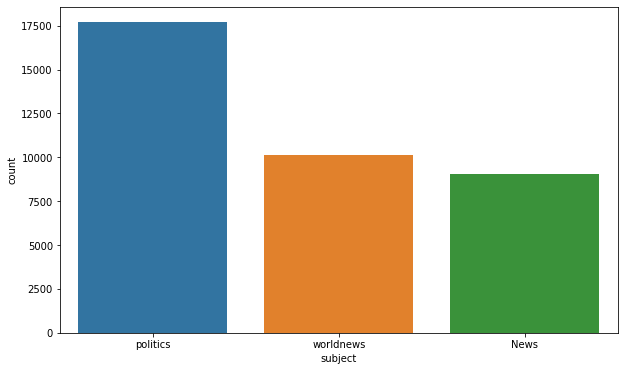

In [18]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import nltk, re
from wordcloud import WordCloud
 
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=topic_news)

## Encodage of the text topics
Since we will construct a tensorflow.keras model, we have to encode the text topics. The subject column corresponds to the target values. We use the LabelEncoder from sklearn to encode the topics.

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(topic_news['subject'].unique())

topic_news['subject'] = le.transform(topic_news['subject'])
le.inverse_transform([0,1,2])

array(['News', 'politics', 'worldnews'], dtype=object)

topic_news['subject'] is now an encoded column.

## Text data cleaning
In this section we preprocess the texts to remove the URLs, the HTML tags, the emails... We apply the cleaning functions we defined at the begining of this notebook.

In [20]:
topic_news['text'] = topic_news['text'].apply(lambda x:str(x).lower().replace('_', ' '))
topic_news['text'] = topic_news['text'].apply(lambda x:remove_html(str(x)))
topic_news['text'] = topic_news['text'].apply(lambda x:_remove_urls(str(x)))
topic_news['text'] = topic_news['text'].apply(lambda x:remove_punctuations(str(x)))
topic_news['text'] = topic_news['text'].apply(lambda x:_remove_emails(str(x)))
topic_news['text'] = topic_news['text'].apply(lambda x:_remove_rt(str(x)))
topic_news['text'] = topic_news['text'].apply(lambda x:_remove_special_chars(str(x)))

## Text Tokenization, indexation
* Tokenization is the process of converting a sequence of characters (such as in a computer program or web page) into a sequence of tokens (strings with an assigned and thus identified meaning).
* Followed the tokenization we create an index of words. In our context, an index  is a python dictionary built from the set of the unique words of our corpus. The corpus is the set of text data stored in topic_news['text'].
* Concretely in this step, we convert all text into a list of integers. X is a list of list of words. XBIS is a list of list of integers.
* We use pad_sequences to pad sequences to the same length. All list of integers in XTIER have the same length.

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()

X = [text.split() for text in list(topic_news['text'])]
tokenizer.fit_on_texts(X)

XBIS = tokenizer.texts_to_sequences(X)
XTIER = pad_sequences(XBIS,maxlen=1000,padding='post')

The index of the corpus is given by tokenizer.word_index .The vocabulary size is given by len(tokenizer.word_index)+1. We add 1 to the length of the index to take into account unknown words. The keys of this dictionary are the set of unique words we get from the corpus.

In [ ]:
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

## Step 4: Splitting the dataset into a training set and a test set
We use the train_test_split method to make a training set and a test set. We have a 3 classes problem, topic_news['subject'].

In [22]:
Y_CAT = topic_news['subject'].to_numpy() #topic_news['subject'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XTIER,Y_CAT,test_size=0.25, random_state=42)

## RNN MODEL WITH A SINGLE LSTM LAYER
* In the following network the first layer is an embedding layer that embedds each word from the vocabulary into a 100 sized dense vector. Some importants arguments of the tf.keras.layers.Embedding are: 
   * input_dim : Size of the vocabulary+1
   * output_dim: Integer. Dimension of the dense embedding.
   * input_length: Length of input sequences. The lenght of our input sequences is set with pad_sequences.
* We want to predict if the topic of a text is about politic,worldnews or news. In other words, we are in the case of a 3 classes problem. Then, the output layer shoud be a dense layer with 3 units. The output layer shoud logically be a dense layer with 3 units with a softmax activation function. We choose categorical_crossentropy loss function. 
* LSTM(units=128) means the dimensionality of the output space is 128. 128 is not the number of elementary LSTM cells we have in our LSTM. We have 1000 elementary LSTM cells in our LSTM Neural network.
* The input $X^{<1>}\in \mathbb{R}^{100}$ for the first elementary LSTM cell is a dense vector. The input for the last elementary LSTM cell $X^{<1000>}\in \mathbb{R}^{100}$ is a dense vector. The LSTM has 1000 elementary cells.

In [27]:
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential

dim = 100
vocab_size = len(tokenizer.word_index)+1

topic_single = Sequential()
topic_single.add(Embedding(input_dim=vocab_size,output_dim=100))
topic_single.add(LSTM(units=128))
topic_single.add(Dense(3,activation='softmax'))

topic_single.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

We fit the topic_single model and evaluate it.

In [28]:
topic_single.fit(X_train,y_train,epochs=6,validation_split=0.1)
topic_single.evaluate(X_test,y_test)

Epoch 1/6
779/779 [==============================] - 48s 60ms/step - loss: 1.0518 - acc: 0.4772 - val_loss: 1.0473 - val_acc: 0.4754
Epoch 2/6
779/779 [==============================] - 46s 59ms/step - loss: 0.6828 - acc: 0.6773 - val_loss: 0.6219 - val_acc: 0.7095
Epoch 3/6
779/779 [==============================] - 49s 64ms/step - loss: 0.6422 - acc: 0.6994 - val_loss: 0.5929 - val_acc: 0.7095
Epoch 4/6
779/779 [==============================] - 46s 59ms/step - loss: 0.5874 - acc: 0.7056 - val_loss: 1.4298 - val_acc: 0.4772
Epoch 5/6
779/779 [==============================] - 46s 59ms/step - loss: 0.6169 - acc: 0.7022 - val_loss: 0.5931 - val_acc: 0.7110
Epoch 6/6
289/289 [==============================] - 6s 19ms/step - loss: 0.6259 - acc: 0.7021


[0.6258708238601685, 0.7021138072013855]

## We test the model on unknown texts

First, we have to make a function able to preprocess and tokenizer unknown texts like we did in the text data cleaning section and the Tokenization section. We call the tokenizer we defined earlier in this example.

In [30]:
new_text = " WATCH STANLEY CUP CHAMPS VISIT White House…Give Trump Coveted \
Gift Video President Trump greeted the NHL s Stanley Cup winning \
Pittsburgh Penguins at the White House today. The President and First Lady were \
on hand to greet the team and coaches. The president was given a small \
replica of the Stanley Cup Very cool!President Trump welcomed \
the Pittsburgh Penguins to the White House on Tuesday to congratulate\
them on their Stanley Cup win." 


from tensorflow.keras.preprocessing.sequence import pad_sequences

def handle_topic(text):
    text1 = str(text).lower().replace('_', ' ')
    text1 = remove_html(str(text1))
    text1 = _remove_urls(str(text1))
    text1 = remove_punctuations(str(text1))
    text1 = _remove_emails(str(text1))
    text1 = _remove_rt(str(text1))
    text1 = _remove_special_chars(str(text1))
    text1 = [text1.split()]
    text1 = tokenizer.texts_to_sequences(text1)
    text1 = pad_sequences(text1,maxlen=1000,padding='post')
    return(text1)

text_vect = handle_topic(new_text)

Now, we can apply the model we've just fitted and we get a probability vector. Then, we apply the label encoder we defined earlier to know the predicted label of the new text.

In [31]:
import numpy as np

#we compute the probability vector of the subject
proba_predict = topic_single.predict(text_vect)

#The predicted subject
print("the predicted subject is: "+str(le.inverse_transform([np.argmax(proba_predict)])[0]))

1/1 [==============================] - 0s 345ms/step
the predicted subject is: politics


## NEURAL NETWORK WITH MULTIPLE LSTM LAYER
In, this section we built neural network with 3 LSTM LAYERS. We don't use this model, We train it with only one epoch.  When we stack multiple LSTM layers we have to set return_sequences to True for all LSTM layers except the last one. You can put a Dropout layer between LSTM LAYERS.

In [34]:
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential


vocab_size = len(tokenizer.word_index)+1


multi_lstm = Sequential()
multi_lstm.add(Embedding(input_dim=vocab_size,output_dim=100))
multi_lstm.add(LSTM(50,return_sequences=True))
multi_lstm.add(Dropout(0.2))
multi_lstm.add(LSTM(32,return_sequences=True))
multi_lstm.add(BatchNormalization())
multi_lstm.add(LSTM(16))
multi_lstm.add(Dense(3,activation='softmax'))

multi_lstm.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [35]:
multi_lstm.fit(X_train,y_train,epochs=1)

865/865 [==============================] - 82s 90ms/step - loss: 1.0492 - acc: 0.4768


## NEURAL NETWORK WITH BIDIRECTIONAL LSTM LAYER

In [37]:
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

DIM = 100 #the size of the emdedding vectors
vocab_size = len(tokenizer.word_index)+1


bidirect_lstm = Sequential()
bidirect_lstm.add(Embedding(input_dim=vocab_size,output_dim=100,input_length=1000))
bidirect_lstm.add(Bidirectional(LSTM(128)))
bidirect_lstm.add(Dense(3,activation='softmax'))

bidirect_lstm.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])